In [1]:
import pandas as pd

import sys
sys.path.append('..')  # Add parent directory to path
from model_pipeline import CreditScoringPipeline
import results_viewer as rv

# 1. Load Processed Data

In [7]:
train_df = pd.read_csv('../data/processed/train_processed.csv')
val_df = pd.read_csv('../data/processed/val_processed.csv')
test_df = pd.read_csv('../data/processed/test_processed.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Validation set shape: {val_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (149986, 25)
Validation set shape: (29998, 25)
Test set shape: (101503, 25)


# 2. Prepare Features and Target

In [8]:
X_train = train_df.drop('SeriousDlqin2yrs', axis=1)
y_train = train_df['SeriousDlqin2yrs']

X_val = val_df.drop('SeriousDlqin2yrs', axis=1)
y_val = val_df['SeriousDlqin2yrs']

# For test set, we don't have the target variable
X_test = test_df

# Combine train and val for final training
X_train = pd.concat([X_train, X_val])
y_train = pd.concat([y_train, y_val])

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")

X_train: (179984, 24), y_train: (179984,)
X_test: (101503, 25)


# 3. Quick scan on a sample (fast)

In [9]:
X_train2 = X_train.reset_index(drop=True)
y_train2 = y_train.reset_index(drop=True)

pipe = CreditScoringPipeline(speed_mode='fast', run_both_smote_by_default=False, default_n_jobs=-1)
models_to_check = list(pipe.get_available_models().keys())

In [11]:
pipe.train_all(
    X_train=X_train2,
    y_train=y_train2,
    model_names=models_to_check,
    run_modes=('no_smote',),
    sample_frac=0.3
)

[INFO] Sampling train: frac=0.3
[INFO] Training model 'LogisticRegression' | speed_mode=fast | search_method=random
[RUN] LogisticRegression / no_smote | n_iter=4 | cv=3 | use_smote=False
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[DONE] LogisticRegression/no_smote | CV AUC=0.8527 | best_params={'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 0.01}
[INFO] Sampling train: frac=0.3
[INFO] Training model 'RandomForest' | speed_mode=fast | search_method=random
[RUN] RandomForest / no_smote | n_iter=7 | cv=3 | use_smote=False
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[DONE] RandomForest/no_smote | CV AUC=0.8522 | best_params={'randomforestclassifier__n_estimators': 100, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__max_depth': 5}
[INFO] Sampling train: frac=0.3
[INFO] Training model 'HistGradientBoosting' | speed_mode=fast | search_method=random
[RUN] HistGradientBoosting / n

{'LogisticRegression': {'no_smote': {'best_estimator': Pipeline(steps=[('logisticregression',
                    LogisticRegression(C=0.01, class_weight='balanced',
                                       max_iter=2000, penalty='l1',
                                       random_state=42, solver='liblinear'))]),
   'best_params': {'logisticregression__solver': 'liblinear',
    'logisticregression__penalty': 'l1',
    'logisticregression__C': 0.01},
   'cv_score': np.float64(0.8527295536782643),
   'search': RandomizedSearchCV(cv=3,
                      estimator=Pipeline(steps=[('logisticregression',
                                                 LogisticRegression(class_weight='balanced',
                                                                    max_iter=2000,
                                                                    random_state=42))]),
                      n_iter=4, n_jobs=-1,
                      param_distributions={'logisticregression__C': [0.01],
       

### See results and plot


===== All models summary =====

               model      run   cv_auc                                                                                                                                              best_params  use_smote  sample_frac speed_mode
HistGradientBoosting no_smote 0.860340 {'histgradientboostingclassifier__max_iter': 100, 'histgradientboostingclassifier__max_depth': 3, 'histgradientboostingclassifier__learning_rate': 0.05}      False          0.3       fast
    GradientBoosting no_smote 0.858070         {'gradientboostingclassifier__n_estimators': 100, 'gradientboostingclassifier__max_depth': 3, 'gradientboostingclassifier__learning_rate': 0.05}      False          0.3       fast
  LogisticRegression no_smote 0.852730                                          {'logisticregression__solver': 'liblinear', 'logisticregression__penalty': 'l1', 'logisticregression__C': 0.01}      False          0.3       fast
        RandomForest no_smote 0.852184                    {

<Figure size 1000x600 with 0 Axes>

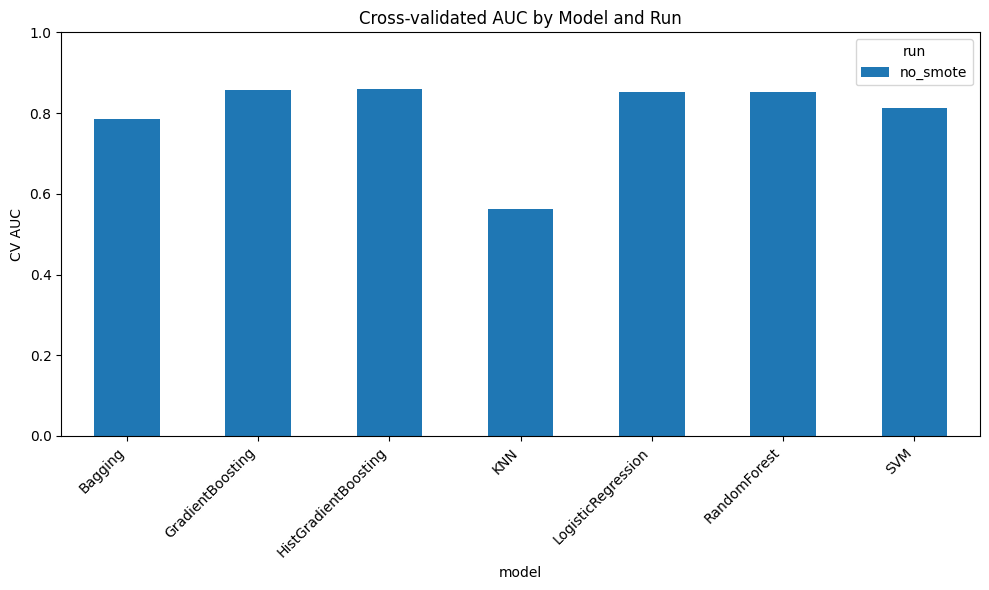

Saved CV AUC barplot to: models/cv_auc_by_model.png


'models/cv_auc_by_model.png'

In [ ]:
# Print full table sorted by cv_auc (descending)
df_scan = rv.render_all_models_report(pipe, sort_by='cv_auc', ascending=False, print_table=True)

# Save CSV and barplot for visual comparison
rv.save_summary_csv(pipe, "models/quick_scan_summary.csv")
rv.plot_cv_auc_bar(pipe, save_dir="models")

## 4. Choose top-4 and run refinement (balanced, full train, compare SMOTE)

In [ ]:
# Choose top N models from df_scan
top_n = 4
top_models = list(df_scan.sort_values('cv_auc', ascending=False)['model'].unique()[:top_n])
print("Top models (quick scan):", top_models)

pipe.speed_mode = 'balanced'

for m in top_models:
    pipe.train_model(
        model_name=m,
        X_train=X_train,
        y_train=y_train,
        run_modes=('no_smote','smote'),
        sample_frac=1.0,
        cv=3,
        n_iter=12 
    )


Top models (quick scan): ['HistGradientBoosting', 'GradientBoosting', 'LogisticRegression', 'RandomForest']
[INFO] Training model 'HistGradientBoosting' | speed_mode=balanced | search_method=random
[RUN] HistGradientBoosting / no_smote | n_iter=12 | cv=3 | use_smote=False
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[DONE] HistGradientBoosting/no_smote | CV AUC=0.8710 | best_params={'histgradientboostingclassifier__max_iter': 100, 'histgradientboostingclassifier__max_depth': 6, 'histgradientboostingclassifier__learning_rate': 0.1}
[RUN] HistGradientBoosting / smote | n_iter=12 | cv=3 | use_smote=True
Fitting 3 folds for each of 8 candidates, totalling 24 fits
[DONE] HistGradientBoosting/smote | CV AUC=0.8628 | best_params={'histgradientboostingclassifier__max_iter': 200, 'histgradientboostingclassifier__max_depth': 6, 'histgradientboostingclassifier__learning_rate': 0.1}
[INFO] Training model 'GradientBoosting' | speed_mode=balanced | search_method=random
[RUN] GradientB

### View refined results and compare


===== All models summary =====

               model      run   cv_auc                                                                                                                                             best_params  use_smote  sample_frac speed_mode
    GradientBoosting no_smote 0.871041         {'gradientboostingclassifier__n_estimators': 200, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__learning_rate': 0.1}      False          1.0   balanced
HistGradientBoosting no_smote 0.870995 {'histgradientboostingclassifier__max_iter': 100, 'histgradientboostingclassifier__max_depth': 6, 'histgradientboostingclassifier__learning_rate': 0.1}      False          1.0   balanced
        RandomForest no_smote 0.868438                  {'randomforestclassifier__n_estimators': 200, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__max_depth': 10}      False          1.0   balanced
HistGradientBoosting    smote 0.862774 {'histgradientboostingcl

<Figure size 1000x600 with 0 Axes>

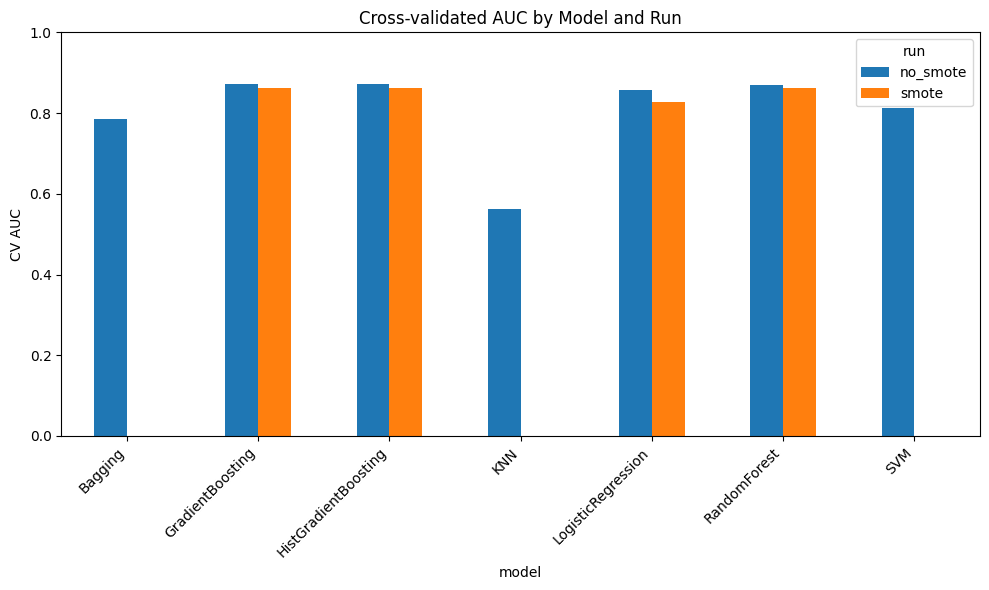

Saved CV AUC barplot to: models/cv_auc_by_model.png


'models/cv_auc_by_model.png'

In [ ]:
# Show updated summary and plot
df_refined = rv.render_all_models_report(pipe, sort_by='cv_auc', ascending=False, print_table=True)
rv.save_summary_csv(pipe, "models/refined_summary.csv")
rv.plot_cv_auc_bar(pipe, save_dir="models")


## 5. Final thorough runs for 2 winners

In [ ]:
final_models = list(
    df_refined.sort_values('cv_auc', ascending=False)['model'].unique()[:2]
)

pipe.speed_mode = 'thorough'

for m in final_models:
    pipe.train_model(
        model_name=m,
        X_train=X_train,
        y_train=y_train,
        run_modes=('no_smote', 'smote'),
        sample_frac=1.0,
        cv=4,
        n_iter=30,
        search_method='grid'
    )

    runs = pipe.models[m]
    for run_key, run_data in runs.items():
        best_estimator = run_data['best_estimator']
        path = f"models/{m}_best_{run_key}.joblib"
        pipe.save_trained_model(m, path=path, use_smote=(run_key == 'smote'))
        print(f"Saved {m} ({run_key}) → {path}")

[INFO] Training model 'GradientBoosting' | speed_mode=thorough | search_method=grid
[RUN] GradientBoosting / no_smote | n_iter=30 | cv=4 | use_smote=False
Fitting 4 folds for each of 8 candidates, totalling 32 fits
[DONE] GradientBoosting/no_smote | CV AUC=0.8715 | best_params={'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 200}
[RUN] GradientBoosting / smote | n_iter=30 | cv=4 | use_smote=True
Fitting 4 folds for each of 8 candidates, totalling 32 fits
[DONE] GradientBoosting/smote | CV AUC=0.8635 | best_params={'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__max_depth': 5, 'gradientboostingclassifier__n_estimators': 200}
Saved: models/GradientBoosting_best_no_smote.joblib
Saved GradientBoosting (no_smote) → models/GradientBoosting_best_no_smote.joblib
Saved: models/GradientBoosting_best_smote.joblib
Saved GradientBoosting (smote) → models/GradientBoosting_best_smo

In [2]:
import joblib

In [3]:
best_models = []

for path in [
    "models/HistGradientBoosting_best_smote.joblib",
    "models/GradientBoosting_best_smote.joblib",
    "models/HistGradientBoosting_best_no_smote.joblib",
    "models/GradientBoosting_best_no_smote.joblib",
]:
    best_models.append(joblib.load(path))

In [9]:
import numpy as np

X_test = test_df
X_test= X_test.drop('SeriousDlqin2yrs', axis=1)

preds = []
for model in best_models:
    p = model.predict_proba(X_test)[:, 1]
    preds.append(p)

preds = np.vstack(preds)

In [10]:
import os
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
SUBMISSION_DIR = os.path.join(PROJECT_ROOT, "data", "submissions")
os.makedirs(SUBMISSION_DIR, exist_ok=True)

In [12]:
submission_base = pd.DataFrame({'Id': X_test.index})

models = [
    "HistGradientBoosting_smote",
    "GradientBoosting_smote",
    "HistGradientBoosting_no_smote",
    "GradientBoosting_no_smote",
]
for i, p in enumerate(preds, start=1):
    df_sub = submission_base.copy()
    df_sub['Probability'] = p
    df_sub['Id'] = df_sub['Id'] + 1
    df_sub_path = os.path.join(SUBMISSION_DIR, f"submission_{models[i - 1]}.csv")
    df_sub.to_csv(df_sub_path, index=False)